# 既存の統計モデル・機械学習モデルでない数学モデルからベイズモデルを構築する

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd
import seaborn as sns
import pymc as pm
import arviz as az
import random

random.seed(42)

In [7]:
# Data
url = 'https://raw.githubusercontent.com/makaishi2/samples/main/data/irt-sample.csv'
df  = pd.read_csv(url, index_col=0)
df

,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,...,Q041,Q042,Q043,Q044,Q045,Q046,Q047,Q048,Q049,Q050
USER0001,0,1,1,1,0,1,1,0,0,0,...,0,0,1,1,0,1,0,1,1,1
USER0002,1,0,1,1,1,0,1,1,0,0,...,0,1,1,0,1,0,0,1,1,0
USER0003,1,0,1,1,1,1,1,1,0,0,...,1,1,1,1,1,1,1,1,1,1
USER0004,1,1,1,1,1,0,1,0,1,0,...,0,0,1,1,1,1,0,0,0,1
USER0005,0,1,0,1,0,0,1,0,1,1,...,1,1,1,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
USER0996,1,1,0,1,1,1,1,0,0,1,...,0,1,1,1,0,0,1,0,0,1
USER0997,0,0,0,1,1,1,1,1,0,1,...,1,1,1,0,1,0,1,1,1,1
USER0998,1,1,0,1,1,1,1,1,1,0,...,1,1,1,1,1,0,0,1,1,1
USER0999,1,0,0,1,1,1,1,0,0,1,...,0,1,1,1,0,0,0,1,0,1


ベイズ推論を行うため、表形式データを観測値として確率モデルに渡す必要があるためデータ加工を行う

In [45]:
# Data 加工
indexes_sample = random.sample(range(len(df)), 20) # 推論に時間がかかり過ぎるため Sample 抽出
df_proc = pd.melt(
    
    df.iloc[indexes_sample].reset_index(),  #
    id_vars='index',
    var_name='question',
    value_name='correct_answer'
)

df_proc = df_proc.rename(columns={'index': 'user'})
df_proc

,user,question,correct_answer
0,USER0800,Q001,0
1,USER0981,Q001,1
2,USER0668,Q001,1
3,USER0042,Q001,0
4,USER0773,Q001,1
...,...,...,...
995,USER0485,Q050,1
996,USER0686,Q050,0
997,USER0118,Q050,1
998,USER0578,Q050,0


In [46]:
# カテゴリーデータの数値化
user_idx, users = pd.factorize(df_proc['user'])  # user_idx: 数値化した user列, users: 対応する文字列達
question_idx, questions = pd.factorize(df_proc['question'])  # question_idx: 数値化した question列, question列: 対応する文字列達
correct_answers = df_proc['correct_answer'].values

print('--- USER ---')
print(user_idx, len(user_idx))
print(users)
print('\n--- QUESTION ---')
print(question_idx, len(questions))
print(questions)
print('\n--- CORRECT ANSWERS ---')
print(correct_answers, len(correct_answers))

--- USER ---
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19  0  1  2  3
  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19  0  1  2  3  4  5  6  7
  8  9 10 11 12 13 14 15 16 17 18 19  0  1  2  3  4  5  6  7  8  9 10 11
 12 13 14 15 16 17 18 19  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15
 16 17 18 19  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19
  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19  0  1  2  3
  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19  0  1  2  3  4  5  6  7
  8  9 10 11 12 13 14 15 16 17 18 19  0  1  2  3  4  5  6  7  8  9 10 11
 12 13 14 15 16 17 18 19  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15
 16 17 18 19  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19
  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19  0  1  2  3
  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19  0  1  2  3  4  5  6  7
  8  9 10 11 12 13 14 15 16 17 18 19  0  1  2  3  4  5  6  7  8  9 10 11
 12 13 14 15 16 17 18 19  0  1  2  3  

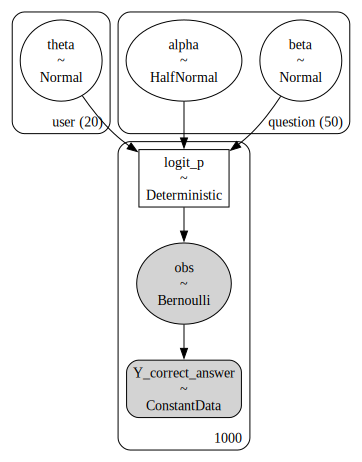

In [47]:
# 確率モデル定義
coords = {'user': users, 'question': questions}  # 項目定義

model_irt = pm.Model(coords=coords)  # インスタンス定義

with model_irt:
    Y_correct_answer = pm.ConstantData('Y_correct_answer', correct_answers)  # 目的変数の観測値（1: 正解, 0: 誤答）
    theta = pm.Normal('theta', mu=0.0, sigma=1.0, dims='user')  # 能力値（受験者ごと）
    alpha = pm.HalfNormal('alpha', sigma=1.0, dims='question')  # 識別力（設問ごと）
    beta = pm.Normal('beta', mu=0.0, sigma=1.0, dims='question')
    # sigma: 2PLM には自由度が１残っているため、alpha と beta のバランスをよくする目的で、1.0 に設定
    
    # logit_p の計算式を定義（２パラメータ・ロジスティックモデル（2PLM））
    logit_p = pm.Deterministic('logit_p', alpha[question_idx] * (theta[user_idx] - beta[question_idx]))
    
    # ベルヌーイ分の定義（1: 正解, 0: 誤答）
    obs = pm.Bernoulli('obs', logit_p=logit_p, observed=Y_correct_answer)  # logit_p= 渡された確率変数に対してシグモイド関数が計算され、結果 p を設定してくれる

# 可視化
pm.model_to_graphviz(model_irt)

## 2PLM（: ２パラメータ・ロジスティックモデル）
### パラメータ
- theta（能力値: 受験者の能力, 受験者固有）
- alpha: （識別力: 受験者のレベルを変えたときに、正答率がどの程度変化するかの度合い, 設問固有）
- beta: （困難度: 各設問の難しさ, 設問固有）

### 正答率を返す関数
$f(x) = \frac{1}{1 + \exp(-x)}$

のシグモイド関数を用いて

$f(\alpha_j(\theta_i - \beta_j))$

In [49]:
# # Sampling
# with model_irt:
#     inference_irt = pm.sample(random_seed=42, chains=2)

**変分推論法**を利用
1. `.fit()` 呼び出し
2. 収束確認
3. サンプリング

In [ ]:
with model_irt:
    field_mean = pm.fit(n=20_000, method=pm.ADVI(), obj_optimizer=pm.adam())

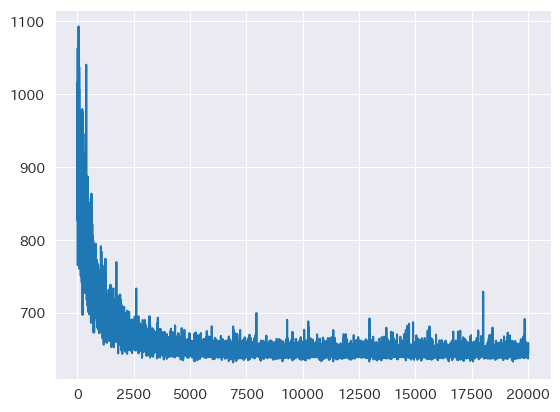

In [52]:
# 変分推論法の収束確認
plt.plot(field_mean.hist)
plt.show()

In [53]:
inference_irt = field_mean.sample(2_000)

In [60]:
#識別力
summary_irt_alpha = az.summary(inference_irt, var_names=['alpha'])
summary_irt_alpha

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[Q001],1.533,0.559,0.660,2.566,0.013,0.009,1877.0,1847.0,NaN
alpha[Q002],0.376,0.299,0.046,0.865,0.007,0.005,1883.0,1766.0,NaN
alpha[Q003],1.280,0.537,0.488,2.298,0.012,0.009,1948.0,1812.0,NaN
alpha[Q004],1.249,0.549,0.410,2.222,0.012,0.009,2101.0,1781.0,NaN
alpha[Q005],1.467,0.538,0.569,2.409,0.013,0.009,1871.0,1715.0,NaN
alpha[Q006],1.406,0.545,0.517,2.337,0.013,0.009,1824.0,1922.0,NaN
alpha[Q007],1.297,0.509,0.525,2.269,0.012,0.008,1951.0,1885.0,NaN
alpha[Q008],0.761,0.390,0.205,1.464,0.009,0.006,1830.0,1817.0,NaN
alpha[Q009],0.427,0.293,0.058,0.935,0.007,0.005,1882.0,1675.0,NaN
alpha[Q010],1.021,0.460,0.344,1.850,0.010,0.007,1944.0,1827.0,NaN


In [76]:
# 困難度
summary_irt_beta = az.summary(inference_irt, var_names=['beta'])
summary_irt_beta.head(10)

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[Q001],-0.683,0.363,-1.382,-0.015,0.008,0.006,2043.0,1895.0,NaN
beta[Q002],0.098,0.725,-1.279,1.390,0.017,0.012,1827.0,1570.0,NaN
beta[Q003],0.223,0.376,-0.452,0.943,0.008,0.006,1982.0,1985.0,NaN
beta[Q004],0.038,0.386,-0.732,0.726,0.009,0.006,2044.0,1982.0,NaN
beta[Q005],-1.426,0.451,-2.309,-0.637,0.010,0.007,1950.0,1684.0,NaN
beta[Q006],-0.313,0.349,-0.956,0.355,0.008,0.006,1983.0,2003.0,NaN
beta[Q007],-0.516,0.380,-1.222,0.188,0.009,0.006,1914.0,1893.0,NaN
beta[Q008],-0.216,0.512,-1.187,0.719,0.012,0.009,1798.0,1844.0,NaN
beta[Q009],0.756,0.700,-0.522,2.140,0.018,0.013,1541.0,1849.0,NaN
beta[Q010],1.010,0.444,0.229,1.850,0.011,0.008,1732.0,2009.0,NaN


In [77]:
# 能力値
summary_irt_theta = az.summary(inference_irt, var_names=['theta'])
summary_irt_theta.head(10)

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta[USER0800],-1.304,0.348,-1.910,-0.616,0.008,0.005,2083.0,1773.0,NaN
theta[USER0981],-0.265,0.318,-0.845,0.320,0.008,0.005,1789.0,1786.0,NaN
theta[USER0668],0.964,0.386,0.251,1.705,0.009,0.006,1927.0,2043.0,NaN
theta[USER0042],-0.488,0.309,-1.058,0.092,0.007,0.005,1945.0,1969.0,NaN
theta[USER0773],1.719,0.432,0.897,2.507,0.009,0.006,2296.0,1839.0,NaN
theta[USER0032],1.103,0.396,0.369,1.867,0.010,0.007,1476.0,2004.0,NaN
theta[USER0973],-1.845,0.396,-2.585,-1.151,0.009,0.007,1821.0,1844.0,NaN
theta[USER0254],1.027,0.375,0.388,1.783,0.009,0.006,1925.0,1853.0,NaN
theta[USER0205],-0.129,0.331,-0.751,0.513,0.007,0.005,2008.0,1654.0,NaN
theta[USER0860],0.974,0.376,0.301,1.697,0.009,0.006,1930.0,1823.0,NaN


#### 偏差値と能力値の関係を分析
受験者Sample ごとのデータを偏差値と同じ方式で正規化し分析してみる。

In [83]:
df_users = pd.DataFrame(df.iloc[indexes_sample].mean(axis=1) * 100, columns=['素点'])  # 受験者ごとの正答率を計算し「素点」とする
values_user = df_users.copy()  # 素点を別変数に複写
values_user_mean, values_user_std = values_user.mean(), values_user.std()
# 素点を偏差値のスケールに補正
standard_score = (values_user - values_user_mean) / values_user_std * 10 + 50
df_users['偏差値'] = standard_score

values_theta = summary_irt_theta['mean']  # 受験者ごとの能力値の平均を抽出
values_theta_mean, values_theta_std = values_theta.mean(), values_theta.std()  # 能力値を偏差値を同じスケールに補正
standard_theta = (values_theta - values_theta_mean) / values_theta_std * 10 + 50
df_users['能力値'] = standard_theta.values

df_users

,素点,偏差値,能力値
USER0800,34.0,34.281664,34.027254
USER0981,46.0,42.411838,44.573235
USER0668,70.0,58.672186,57.047740
USER0042,44.0,41.056809,42.309757
USER0773,78.0,64.092302,64.711085
USER0032,72.0,60.027215,58.458608
USER0973,28.0,30.216577,28.536036
USER0254,68.0,57.317157,57.687198
USER0205,52.0,46.476925,45.953652
USER0860,68.0,57.317157,57.149241


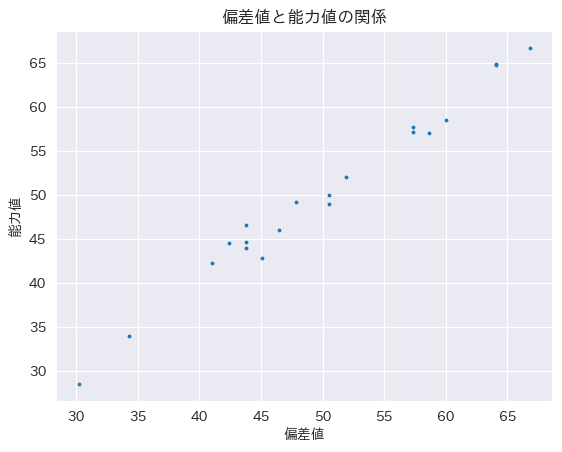

In [87]:
# 偏差値と能力値の散布図
plt.scatter(df_users['偏差値'], df_users['能力値'], s=3)
plt.title('偏差値と能力値の関係')
plt.xlabel('偏差値')
plt.ylabel('能力値')
plt.show()

能力値を使うことで、従来の偏差値による受験者の評価をより精緻に行える可能性がある。

#### 同じ偏差値の受験者間の能力値の比較
個別ケースで確認する。

In [92]:
df_users['素点'].value_counts()

48.0    3
78.0    2
68.0    2
58.0    2
34.0    1
46.0    1
70.0    1
44.0    1
72.0    1
28.0    1
52.0    1
60.0    1
82.0    1
50.0    1
54.0    1
Name: 素点, dtype: int64

In [101]:
df_sample = df_users.loc[df_users['素点'] == 48.0]
arg_min = df_sample['能力値'].values.argmin()
arg_max = df_sample['能力値'].values.argmax()

print(f'Sample_user_score_min: {df_sample.iloc[arg_min]}')
print(f'Sample_user_score_max: {df_sample.iloc[arg_max]}')


Sample_user_score_min: 素点     48.000000
偏差値    43.766867
能力値    43.913477
Name: USER0637, dtype: float64
Sample_user_score_max: 素点     48.000000
偏差値    43.766867
能力値    46.572810
Name: USER0971, dtype: float64


In [102]:
# ２人の受験者の問題ごとの正答
df_sample_user = df.loc[['USER0637', 'USER0971']]
df_sample_user

,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,...,Q041,Q042,Q043,Q044,Q045,Q046,Q047,Q048,Q049,Q050
USER0637,0,1,1,0,1,0,0,0,1,0,...,1,0,1,1,0,0,0,0,1,1
USER0971,1,0,0,1,1,1,1,1,1,0,...,0,0,1,1,1,0,1,0,0,1


In [103]:
# 正解数
sum_correct_answer = df_sample_user.sum(axis=1)
sum_correct_answer

USER0637    24
USER0971    24
dtype: int64

In [108]:
# 問題別の平均困難度
beta_mean = az.summary(inference_irt, var_names=['beta'])['mean'].values.reshape(1, -1)
beta_mean.shape

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


(1, 50)

In [110]:
# ２人の受験者が解いた問題の平均困難度
beta_mean_sampler = (df_sample_user * beta_mean).sum(axis=1) / sum_correct_answer.iloc[0]
beta_mean_sampler

USER0637   -0.348708
USER0971   -0.439667
dtype: float64

`USER0637` の正解した問題の平均困難度は、`USER0971` が正解した問題の平均困難度が高かった。    
つまり、難しい問題が多かったということになる。

In [117]:
sample_theta = inference_irt['posterior'].data_vars['theta'].loc[:, :, ['USER0637', 'USER0971']].values
sample_theta_reshape = sample_theta.transpose().reshape(2, -1)
scale_theta = (sample_theta_reshape - values_theta_mean) / values_theta_std * 10 + 50

df_theta_sampler = pd.DataFrame(scale_theta.T, columns=['USER0637', 'USER0971'])
df_theta_sampler

,USER0637,USER0971
0,45.617133,46.386082
1,45.405730,48.658567
2,47.417654,47.558085
3,43.870223,44.059854
4,42.364339,44.505956
...,...,...
1995,42.704432,50.050505
1996,39.166830,44.835211
1997,41.050851,41.514347
1998,41.326239,51.290551


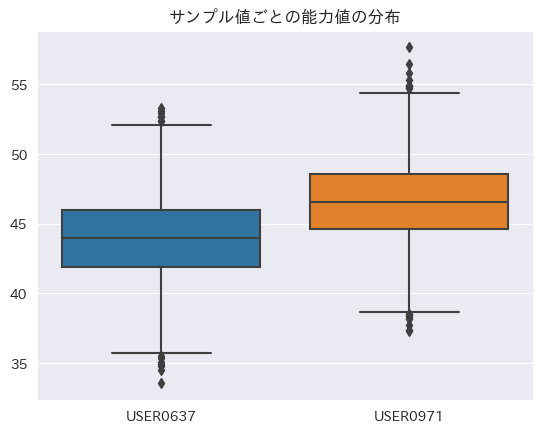

In [119]:
# 可視化
sns.boxplot(df_theta_sampler)
plt.title('サンプル値ごとの能力値の分布')
plt.show()

得点が同じだった２名の受験者は、本来の能力としては違いあった。     
たまたま特定の試験の出来不出来によって、点数が同じであったことが示唆される